In [1]:
# SETUP

import contextlib
import pathlib
import shutil

from pyiron_core import util

json_file_location = util.STORED_WORKFLOW_DIR

lpg = util.LocalPostgres()
lpg.boot()

Local mode - booting LocalPostgres
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', 'stop')
waiting for server to shut down.... done
server stopped
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', 'status')
Running ('initdb', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata')
The files belonging to this database system will be owned by user "liamhuber".
This user must also own the server process.

The database cluster will be initialized with this locale configuration:
  locale provider:   libc
  LC_COLLATE:  C
  LC_CTYPE:    UTF-8
  LC_MESSAGES: C
  LC_MONETARY: C
  LC_NUMERIC:  C
  LC_TIME:     C
The default database encoding has accordingly been set to "UTF8".
The default text search configuration will be set to "simple".

Data page checksums are disabled.

fixing permissions on existing directory /Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata ... ok
creating subdirectories ... ok
selecting dynamic shar

initdb: could not find suitable text search configuration for locale "UTF-8"


ok
syncing data to disk ... ok


Success. You can now start the database server using:

    pg_ctl -D /Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata -l logfile start

Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', '-o', '-p 5432', '-l', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata/logfile', 'start')
waiting for server to start.... done
server started


initdb: warning: enabling "trust" authentication for local connections
initdb: hint: You can change this by editing pg_hba.conf or using the option -A, or --auth-local and --auth-host, the next time you run initdb.


Running ('createuser', '-p', '5432', '-s', 'localuser')
Running ('createdb', '-p', '5432', '-O', 'localuser', 'localdb')
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', 'stop')
waiting for server to shut down.... done
server stopped
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', '-o', '-p 5432', '-l', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata/logfile', 'start')
waiting for server to start.... done
server started


In [2]:
%config IPCompleter.evaluation='unsafe'

import concurrent.futures
import copy
import importlib
import json
import math
import pickle
from typing import Optional


import black
import executorlib
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy import orm


import pyiron_core as pc
import pyiron_core.pyiron_database.api as pyiron_database
from pyiron_core import nodes
from pyiron_core.pyiron_workflow.api import graph as base


In [3]:
pf = pc.PyironFlow(
    ['murnaghan2', 'energy', 'murn4', 'db'], 
    hash_nodes=True, 
    db=pyiron_database.PostgreSQLInstanceDatabase(lpg.connection_string),
    workflow_path=json_file_location,
) # 'landau2',
pf.gui

Database created: <pyiron_core.pyiron_database.instance_database.PostgreSQLInstanceDatabase.PostgreSQLInstanceDatabase object at 0x16ab566f0>


In [4]:
# MUST ENSURE `'murn4'` graph is the active one -- how to do this with code?
# We could go back and manually change the order they are loaded in,
# but I want to see what is required to actually select one
def select_graph_by_name(pf: pc.PyironFlow, graph_label: str):
    pf.tab_widget.selected_index = [w.graph.label for w in pf.wf_widgets].index(graph_label)

select_graph_by_name(pf, "murn4")

graph = pf.graph
graph = base.update_execution_graph(graph, debug=True)
nodeB = graph.nodes["BulkStaticEnergyF"].node
nodeI = graph.nodes["IterNode"].node

pyiron_database.get_hash(nodeB), id(nodeB), id(nodeI.inputs.node.value.node)

Updating input BulkStaticEnergyF in node BulkStaticEnergyF out node 6107307312 6107307312
Updating input Linspace in node Linspace linspace kwarg_list 6107577856 6107577856
Updating input CreateDB in node CreateDB db _db 6107576608 6107576608
Updating input CreateDB in node CreateDB db _db 6107576608 6107576608
Updating input CreateDB in node CreateDB db db 6107576608 6107576608


('0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d18c0abf15865f28850a',
 6107307312,
 6107307312)

In [5]:
id(nodeB.outputs.out.node), id(nodeB)

(6107307312, 6107307312)

In [6]:
nodeI.outputs.data.keys()

dict_keys(['label', 'type', 'ready', 'value', 'node'])

In [7]:
nodeB.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,a,float,None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
2,store,bool,True,True,True,<pyiron_core.pyiron_workflow.simple_workflow.N...
3,_db,NotHinted,None,True,label ...,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [8]:
nodeI.inputs.node.value

label                                                  out
type                                     builtins.NoneType
ready                                                False
value                                                 None
node     <pyiron_core.pyiron_workflow.simple_workflow.N...
dtype: object

In [9]:
pyiron_database.get_hash(nodeI.inputs.node.value.node)

'0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d18c0abf15865f28850a'

In [10]:
nodeI.inputs.node.value.node.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,a,float,None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
2,store,bool,True,True,True,<pyiron_core.pyiron_workflow.simple_workflow.N...
3,_db,NotHinted,None,True,label ...,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [11]:
base._find_input_nodes(base._remove_node_inputs(graph), 1)

[2, 3, 1]

In [12]:
@pc.as_function_node("energy")
def BulkStaticEnergy(name: str, a: float = None):

    from pyiron_core import nodes, Workflow

    wf = Workflow('subgraph')

    wf.Bulk = nodes.atomistic.structure.build.Bulk(name=name, a=a)
    wf.M3GNet = nodes.atomistic.engine.ase.M3GNet()
    wf.Static = nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static)

    out = wf.GetEnergyLast.pull()

    return out

    # return wf.GetEnergyLast.outputs.energy_last

In [13]:
@pc.as_macro_node(["BulkStaticEnergy", "BulkStructure"])
def BulkStaticEnergy(name: str, a: float = None):

    from pyiron_core import nodes, Workflow

    wf = Workflow('subgraph')

    wf.Bulk = nodes.atomistic.structure.build.Bulk(name=name, a=a)
    wf.M3GNet = nodes.atomistic.engine.ase.M3GNet()
    wf.Static = nodes.atomistic.calculator.ase.Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = nodes.atomistic.calculator.output.GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last, wf.Bulk

In [14]:
args = ["BulkStaticEnergy", "BulkStructure"]
if isinstance(args[0], str):
    output_labels = list(args)
else:
    output_labels = None
output_labels

['BulkStaticEnergy', 'BulkStructure']

In [15]:
out = BulkStaticEnergy(name='Al').run()
out

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

(-3.701530933380127,
 Al: [0. 0. 0.]
 tags: 
     indices: [0]
 pbc: [ True  True  True]
 cell: 
 Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]]))

In [16]:
select_graph_by_name(pf, "murnaghan2")
pf.graph.nodes["subgraph"].node.node_type

'graph'

In [17]:
base.get_inputs_of_graph(pf.graph.nodes["subgraph"].graph, exclude_unconnected_default_ports=True)

,label,value,type,default,ready
0,Bulk__name,Al,str,NotData,True
1,Bulk__a,2,Optional[float],None,True


In [18]:
print(base.get_code_from_graph(pf.graph.nodes["subgraph"].graph))


def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



In [19]:
pf.db

From here on, we need the database to actually be populated with results from our workflows. Since this is not part of our static data, obtain it by simply re-running each of the existing workflows.

In [20]:
def pull_all_terminal_nodes(graph: base.Graph, _verbose: bool = False):
    graph_copy = base.get_updated_graph(graph)
    for label, graph_node in graph_copy.nodes.items():
        is_virtual = (
            graph_node.node_type != "node" # Is this true? Is a "graph" node_type always virtual?
            and graph_node.node is not None  # These are virtual IO nodes
        )
        is_terminal = label not in graph.edges.df["source"].values
        
        if is_terminal and not is_virtual:
            if _verbose:
                print("Pulling", label)
            base.pull_node(graph_copy, label, db=pf.db)

for wfw in pf.wf_widgets:
    if wfw.graph.label == "db":
        # The GetGraph node of this workflow fails for the stored "node_id" of 20
        # It also fails if I go back and set this to 0
        # I don't know what should be in the database at this point, but it isn't
        continue
    print("Ensuring execution for", wfw.graph.label)
    pull_all_terminal_nodes(wfw.graph)

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

Ensuring execution for murnaghan2
Running node Linspace
Running node CreateDB
Running node IterNode
Restoring node outputs  ef1ceb7bdd503d6a9f67e4a5d6acc65e29333975848be10d98eb065999a993c8 IterNode False
No stored data found for node:  IterNode
copy node (port):  subgraph af664f1e71b0ce7d5a6da1ec806b4f24be3f8e2bebb75cda2a9717f4e24c552f


DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/U

serialization needed
Running node CreateDB
Running node ShowTable
Ensuring execution for energy
Running node Bulk
Running node M3GNet
Running node CreateDB
Running node Static
Running node GetEnergyLast
Restoring node outputs  aad4d0c9828ce452d888a801816d13c706b7b155ca630c35b9a23e1b1e2bc63a GetEnergyLast False
No stored data found for node:  GetEnergyLast
serialization not needed
Running node CreateDB
Running node ShowTable
Ensuring execution for murn4
Running node Linspace
Running node CreateDB
Running node IterNode
Restoring node outputs  3cb9cbdac90bf946399190329b9d76df3a7151aacd6ffaf05157d68a4c4309b9 IterNode False
No stored data found for node:  IterNode
copy node (port):  BulkStaticEnergyF 0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d18c0abf15865f28850a
Restoring node outputs  a7c68e4044a3c8e2aee51546491aa5b52b9cafc4a842f877022057c791c30cd9 BulkStaticEnergyF False
No stored data found for node:  BulkStaticEnergyF
serialization not needed
Restoring node outputs  3fb9126cc5ada3ed58

DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!


serialization not needed
Restoring node outputs  37b011b59638a23c639974b2b5cc4703d87851563376a0fa024b7ba4dc003737 BulkStaticEnergyF False
No stored data found for node:  BulkStaticEnergyF
serialization not needed
Restoring node outputs  b63781c862f7b465beff713f53ff5c49c97f10e9b4f0ba276dcf7be67b7f0c33 BulkStaticEnergyF False
No stored data found for node:  BulkStaticEnergyF
serialization not needed
Restoring node outputs  e69c784d41aa185a10fb42835a305ec0eb4b5600f76e468114e079616b59f62e BulkStaticEnergyF False
No stored data found for node:  BulkStaticEnergyF
serialization not needed
serialization not needed
serialization needed
Running node CreateDB
Running node ShowTable


In [21]:
select_graph_by_name(pf, "murn4")
pf.graph.nodes["ShowTable"].node.outputs.df.value

,hash,qualname,module,version,connected_inputs,inputs,outputs,output_path,master_hash,start_time,cpu_time,executor,user
0,abafeae96775cd856b66a29e3de600f6a434df19701926...,subgraph,pyiron_core.pyiron_workflow.graph.base,not_defined,[],"{'Bulk__a': 2.2, 'Bulk__name': 'Al'}",[GetEnergyLast__energy_last],None,af664f1e71b0ce7d5a6da1ec806b4f24be3f8e2bebb75c...,2025-09-10 17:22:53.602083,0.047643,None,liamhuber
1,0e96ec544f9e348c903604476973f36ba7e16ea3ca060f...,Linspace,pyiron_core.pyiron_nodes.math,not_defined,[],"{'x_max': 2.2, 'x_min': 1.8, 'endpoint': True,...",[linspace],None,None,2025-09-10 17:22:53.096406,0.000070,None,liamhuber
2,c4a3041f12f5e8acd8c9a454dbdda1e59bc7f0e0a89a54...,CreateDB,pyiron_core.pyiron_nodes.databases.node_hash_db,not_defined,[],"{'host': 'localhost', 'port': 5432, 'user': 'l...",[db],None,None,2025-09-10 17:22:53.096497,0.042077,None,liamhuber
3,131d82f2f1b3c1487bedcbabea4594866d8dc2d55372f5...,IterNode,pyiron_core.pyiron_nodes.executors,not_defined,"[node, kwarg_list, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[df],/Users/liamhuber/.storage/131d82f2f1b3c1487bed...,None,2025-09-10 17:22:53.177687,0.472174,None,liamhuber
4,ea65a5fd008614403d9cf6ab7dd30913661fe9f8166e00...,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,not_defined,[],"{'a': None, 'c': None, 'u': None, 'name': 'Al'...",[structure],None,None,2025-09-10 17:22:53.667117,0.000187,None,liamhuber
5,52cde6d28c1d4b01c21051ffcf4792ffc9df625e65937a...,M3GNet,pyiron_core.pyiron_nodes.atomistic.engine.ase,not_defined,[],{'model': 'M3GNet-MP-2021.2.8-PES'},[out],None,None,2025-09-10 17:22:53.667315,0.015681,None,liamhuber
6,18a56dddc1d549054d6320c221f7d581672b974e3b0496...,Static,pyiron_core.pyiron_nodes.atomistic.calculator.ase,not_defined,"[structure, engine]",{'engine': '52cde6d28c1d4b01c21051ffcf4792ffc9...,[out],None,None,2025-09-10 17:22:53.688469,0.007643,None,liamhuber
7,aad4d0c9828ce452d888a801816d13c706b7b155ca630c...,GetEnergyLast,pyiron_core.pyiron_nodes.atomistic.calculator....,not_defined,"[calculator, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[energy_last],/Users/liamhuber/.storage/aad4d0c9828ce452d888...,None,2025-09-10 17:22:53.703237,0.003726,None,liamhuber
8,a7c68e4044a3c8e2aee51546491aa5b52b9cafc4a842f8...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.0, '_db': 'c4a3041f12f5e8acd8c9a454dbd...",[out],/Users/liamhuber/.storage/a7c68e4044a3c8e2aee5...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.735265,0.034199,None,liamhuber
9,3fb9126cc5ada3ed584f138b083853417091e81358d282...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.6666666666666665, '_db': 'c4a3041f12f5...",[out],/Users/liamhuber/.storage/3fb9126cc5ada3ed584f...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.778497,0.028515,None,liamhuber


In [22]:
select_graph_by_name(pf, "murn4")
pf.graph.nodes["ShowTable"].node.outputs.df.value.iloc[7].hash

'aad4d0c9828ce452d888a801816d13c706b7b155ca630c35b9a23e1b1e2bc63a'

In [23]:
db = pf.db

In [24]:
Session = orm.sessionmaker(bind=db.engine)
session = Session()

df = pd.read_sql(session.query(db.table).statement, session.bind)

session.close()

_, graph = pyiron_database.restore_node_from_database(db=db, node_hash=df.hash.iloc[6]) #[19])
pc.GuiGraph(graph)

ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [25]:
df

,hash,qualname,module,version,connected_inputs,inputs,outputs,output_path,master_hash,start_time,cpu_time,executor,user
0,abafeae96775cd856b66a29e3de600f6a434df19701926...,subgraph,pyiron_core.pyiron_workflow.graph.base,not_defined,[],"{'Bulk__a': 2.2, 'Bulk__name': 'Al'}",[GetEnergyLast__energy_last],None,af664f1e71b0ce7d5a6da1ec806b4f24be3f8e2bebb75c...,2025-09-10 17:22:53.602083,0.047643,None,liamhuber
1,0e96ec544f9e348c903604476973f36ba7e16ea3ca060f...,Linspace,pyiron_core.pyiron_nodes.math,not_defined,[],"{'x_max': 2.2, 'x_min': 1.8, 'endpoint': True,...",[linspace],None,None,2025-09-10 17:22:53.096406,0.000070,None,liamhuber
2,c4a3041f12f5e8acd8c9a454dbdda1e59bc7f0e0a89a54...,CreateDB,pyiron_core.pyiron_nodes.databases.node_hash_db,not_defined,[],"{'host': 'localhost', 'port': 5432, 'user': 'l...",[db],None,None,2025-09-10 17:22:53.096497,0.042077,None,liamhuber
3,131d82f2f1b3c1487bedcbabea4594866d8dc2d55372f5...,IterNode,pyiron_core.pyiron_nodes.executors,not_defined,"[node, kwarg_list, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[df],/Users/liamhuber/.storage/131d82f2f1b3c1487bed...,None,2025-09-10 17:22:53.177687,0.472174,None,liamhuber
4,ea65a5fd008614403d9cf6ab7dd30913661fe9f8166e00...,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,not_defined,[],"{'a': None, 'c': None, 'u': None, 'name': 'Al'...",[structure],None,None,2025-09-10 17:22:53.667117,0.000187,None,liamhuber
5,52cde6d28c1d4b01c21051ffcf4792ffc9df625e65937a...,M3GNet,pyiron_core.pyiron_nodes.atomistic.engine.ase,not_defined,[],{'model': 'M3GNet-MP-2021.2.8-PES'},[out],None,None,2025-09-10 17:22:53.667315,0.015681,None,liamhuber
6,18a56dddc1d549054d6320c221f7d581672b974e3b0496...,Static,pyiron_core.pyiron_nodes.atomistic.calculator.ase,not_defined,"[structure, engine]",{'engine': '52cde6d28c1d4b01c21051ffcf4792ffc9...,[out],None,None,2025-09-10 17:22:53.688469,0.007643,None,liamhuber
7,aad4d0c9828ce452d888a801816d13c706b7b155ca630c...,GetEnergyLast,pyiron_core.pyiron_nodes.atomistic.calculator....,not_defined,"[calculator, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[energy_last],/Users/liamhuber/.storage/aad4d0c9828ce452d888...,None,2025-09-10 17:22:53.703237,0.003726,None,liamhuber
8,a7c68e4044a3c8e2aee51546491aa5b52b9cafc4a842f8...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.0, '_db': 'c4a3041f12f5e8acd8c9a454dbd...",[out],/Users/liamhuber/.storage/a7c68e4044a3c8e2aee5...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.735265,0.034199,None,liamhuber
9,3fb9126cc5ada3ed584f138b083853417091e81358d282...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.6666666666666665, '_db': 'c4a3041f12f5...",[out],/Users/liamhuber/.storage/3fb9126cc5ada3ed584f...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.778497,0.028515,None,liamhuber


In [26]:
some_valid_hash = df["hash"].iloc[0]
df.query(f"hash == '{some_valid_hash}'").iloc[0]

hash                abafeae96775cd856b66a29e3de600f6a434df19701926...
qualname                                                     subgraph
module                         pyiron_core.pyiron_workflow.graph.base
version                                                   not_defined
connected_inputs                                                   []
inputs                           {'Bulk__a': 2.2, 'Bulk__name': 'Al'}
outputs                                  [GetEnergyLast__energy_last]
output_path                                                      None
master_hash         af664f1e71b0ce7d5a6da1ec806b4f24be3f8e2bebb75c...
start_time                                 2025-09-10 17:22:53.602083
cpu_time                                                     0.047643
executor                                                         None
user                                                        liamhuber
Name: 0, dtype: object

In [27]:
nodes.atomistic.structure.build.Bulk('Al')._func.__qualname__

'Bulk'

In [28]:
select_graph_by_name(pf, "murn4")
df = pf.graph.nodes["IterNode"].node.outputs.df.value
state = df.__getstate__()
print(state)

df_new = pd.DataFrame()
df_new._mgr = state["_mgr"]
df_new._metadata = state["_metadata"]
df_new2 = pd.DataFrame()
df_new2.__setstate__(state)
df_new2

{'_mgr': BlockManager
Items: Index(['a', 'result'], dtype='object')
Axis 1: RangeIndex(start=0, stop=7, step=1)
NumpyBlock: slice(0, 2, 1), 2 x 7, dtype: float64, '_typ': 'dataframe', '_metadata': [], 'attrs': {}, '_flags': {'allows_duplicate_labels': True}}


,a,result
0,3.000000,2.528607
1,3.666667,-3.223616
2,4.333333,-3.567102
3,5.000000,-2.563248
4,5.666667,-0.607272
5,6.333333,0.184764
6,7.000000,-0.148894


In [29]:
node = pf.graph.nodes["IterNode"].node

In [30]:
user = 'localuser'
password = 'none'
host = 'localhost'
port = '5432'
database = 'localdb'

connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'
engine = sqlalchemy.create_engine(connection_str)
engine.connect()

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
table_names

['nodes']

In [31]:
node = pf.graph.nodes["IterNode"].node

db = pyiron_database.PostgreSQLInstanceDatabase(connection_str)

In [32]:
type(db)

pyiron_core.pyiron_database.instance_database.PostgreSQLInstanceDatabase.PostgreSQLInstanceDatabase

In [33]:
Session = orm.sessionmaker(bind=db.engine)
session = Session()

df = pd.read_sql(session.query(db.table).statement, session.bind)

df

,hash,qualname,module,version,connected_inputs,inputs,outputs,output_path,master_hash,start_time,cpu_time,executor,user
0,abafeae96775cd856b66a29e3de600f6a434df19701926...,subgraph,pyiron_core.pyiron_workflow.graph.base,not_defined,[],"{'Bulk__a': 2.2, 'Bulk__name': 'Al'}",[GetEnergyLast__energy_last],None,af664f1e71b0ce7d5a6da1ec806b4f24be3f8e2bebb75c...,2025-09-10 17:22:53.602083,0.047643,None,liamhuber
1,0e96ec544f9e348c903604476973f36ba7e16ea3ca060f...,Linspace,pyiron_core.pyiron_nodes.math,not_defined,[],"{'x_max': 2.2, 'x_min': 1.8, 'endpoint': True,...",[linspace],None,None,2025-09-10 17:22:53.096406,0.000070,None,liamhuber
2,c4a3041f12f5e8acd8c9a454dbdda1e59bc7f0e0a89a54...,CreateDB,pyiron_core.pyiron_nodes.databases.node_hash_db,not_defined,[],"{'host': 'localhost', 'port': 5432, 'user': 'l...",[db],None,None,2025-09-10 17:22:53.096497,0.042077,None,liamhuber
3,131d82f2f1b3c1487bedcbabea4594866d8dc2d55372f5...,IterNode,pyiron_core.pyiron_nodes.executors,not_defined,"[node, kwarg_list, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[df],/Users/liamhuber/.storage/131d82f2f1b3c1487bed...,None,2025-09-10 17:22:53.177687,0.472174,None,liamhuber
4,ea65a5fd008614403d9cf6ab7dd30913661fe9f8166e00...,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,not_defined,[],"{'a': None, 'c': None, 'u': None, 'name': 'Al'...",[structure],None,None,2025-09-10 17:22:53.667117,0.000187,None,liamhuber
5,52cde6d28c1d4b01c21051ffcf4792ffc9df625e65937a...,M3GNet,pyiron_core.pyiron_nodes.atomistic.engine.ase,not_defined,[],{'model': 'M3GNet-MP-2021.2.8-PES'},[out],None,None,2025-09-10 17:22:53.667315,0.015681,None,liamhuber
6,18a56dddc1d549054d6320c221f7d581672b974e3b0496...,Static,pyiron_core.pyiron_nodes.atomistic.calculator.ase,not_defined,"[structure, engine]",{'engine': '52cde6d28c1d4b01c21051ffcf4792ffc9...,[out],None,None,2025-09-10 17:22:53.688469,0.007643,None,liamhuber
7,aad4d0c9828ce452d888a801816d13c706b7b155ca630c...,GetEnergyLast,pyiron_core.pyiron_nodes.atomistic.calculator....,not_defined,"[calculator, _db]",{'_db': 'c4a3041f12f5e8acd8c9a454dbdda1e59bc7f...,[energy_last],/Users/liamhuber/.storage/aad4d0c9828ce452d888...,None,2025-09-10 17:22:53.703237,0.003726,None,liamhuber
8,a7c68e4044a3c8e2aee51546491aa5b52b9cafc4a842f8...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.0, '_db': 'c4a3041f12f5e8acd8c9a454dbd...",[out],/Users/liamhuber/.storage/a7c68e4044a3c8e2aee5...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.735265,0.034199,None,liamhuber
9,3fb9126cc5ada3ed584f138b083853417091e81358d282...,BulkStaticEnergyF,pyiron_core.pyiron_nodes.local_workflows.test,not_defined,[_db],"{'a': 3.6666666666666665, '_db': 'c4a3041f12f5...",[out],/Users/liamhuber/.storage/3fb9126cc5ada3ed584f...,0fecb738a6b6772cf4c7e2780fbcee8290bcaa064759d1...,2025-09-10 17:22:53.778497,0.028515,None,liamhuber


In [34]:
pf = pc.PyironFlow(['assyst', 'linearfit2', 'graph', 'executor', 'executor2', 'murnaghan', 'murnaghan2'], workflow_path=json_file_location) # 'landau2',
pf.gui

In [35]:
select_graph_by_name(pf, "murnaghan2")
# could also be "executor2" -- both have "subgraph" and "Linspace" nodes
label ="subgraph"
label = "Linspace"
pf.graph.nodes[label].node.copy()._graph_node == pf.graph.nodes[label]

True

In [36]:
new_node = pickle.loads(pickle.dumps(pf.graph.nodes["subgraph"]))
new_node.node

In [37]:
base.GraphNode().__setstate__(pf.graph.nodes["subgraph"].__getstate__()).node.run()

/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

53.408348083496094

In [38]:
wf = pc.Workflow("test")
wf.bulk = nodes.atomistic.structure.build.Bulk("Al", cubic=True)
wf.volume = nodes.atomistic.structure.calc.Volume(wf.bulk)

wf.range = nodes.math.Linspace(1.8, 2.2, 7)

graph = base.get_graph_from_wf(wf, [], [])
graph_sub = base.create_group(graph, [0, 2])

base.get_updated_graph(graph_sub)

labels ['bulk__name', 'bulk__cubic']
inp:  bulk name
GraphEdge(source='va_i_subgraph__bulk__name', target='bulk', sourceHandle='x', targetHandle='name')
inp:  bulk cubic
GraphEdge(source='va_i_subgraph__bulk__cubic', target='bulk', sourceHandle='x', targetHandle='cubic')
labels ['volume__volume']
node:  bulk GraphNode(id='bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='bulk', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eb5dc40>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  range GraphNode(id='range', import_path='pyiron_core.pyiron_nodes.math.Linspace', label='range', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eb215b0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  volume GraphNode(id='volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='volume

Graph(id=None, label='test', root_node=None, nodes=Nodes({'subgraph': GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ea16240>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'bulk': GraphNode(id='bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eb5dc40>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'volume': GraphNode(id='volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='volume', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eb224b0>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='bulk', target='volume', sourceHandle='structure', targetHandle='structure')]

In [39]:
wf_file = json_file_location / "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))

sub_nodes= graph_dict["nodes"]["subgraph"]["graph"]["nodes"]
sub_nodes

{'Bulk': {'id': 'Bulk',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk',
  'label': 'Bulk',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Bulk',
   'function': 'pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk',
   'inputs': {'name': 'Al', 'a': 2}}},
 'M3GNet': {'id': 'M3GNet',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.engine.ase.M3GNet',
  'label': 'M3GNet',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'M3GNet',
   'function': 'pyiron_core.pyiron_nodes.atomistic.engine.ase.M3GNet',
   'inputs': {}}},
 'Static': {'id': 'Static',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.calculator.ase.Static',
  'label': 'Static',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded'

In [40]:
wf_file = json_file_location / "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))

loaded_graph = base.Graph().__setstate__(graph_dict)

subgraph = base.Graph().__setstate__(graph_dict["nodes"]["subgraph"]["graph"])

subgraph.nodes._obj_type is None

False

In [41]:
graph_dict["nodes"]["subgraph"]["graph"]["nodes"]

{'Bulk': {'id': 'Bulk',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk',
  'label': 'Bulk',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'Bulk',
   'function': 'pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk',
   'inputs': {'name': 'Al', 'a': 2}}},
 'M3GNet': {'id': 'M3GNet',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.engine.ase.M3GNet',
  'label': 'M3GNet',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded': False,
  'node': {'label': 'M3GNet',
   'function': 'pyiron_core.pyiron_nodes.atomistic.engine.ase.M3GNet',
   'inputs': {}}},
 'Static': {'id': 'Static',
  'import_path': 'pyiron_core.pyiron_nodes.atomistic.calculator.ase.Static',
  'label': 'Static',
  'parent_id': None,
  'level': 0,
  'graph': None,
  'node_type': 'node',
  'widget_type': 'customNode',
  'expanded'

In [42]:
loaded_graph.nodes._obj_type

pyiron_core.pyiron_workflow.graph.base.GraphNode

The decorator functions of Nodes are a constant source of errors. Can we make them more elegant and robust by going from decorator arguments to class inheritance?? Do I really need something like ob_type? I know the type I want to get from the name, i.e., nodes should have always GraphNode elements.

In [43]:
subgraph = base._load_graph("murnaghan2", workflow_dir=json_file_location).nodes["subgraph"]
print('xxx: ', base.graph_to_code(subgraph.graph))

pc.GuiGraph(subgraph.graph)

xxx:  
def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [44]:
wf_file = json_file_location / "murnaghan2.json"
with open(wf_file, "r") as f:
    graph_dict = (json.load(f))

loaded_graph = base.Graph().__setstate__(graph_dict)

subgraph2 = loaded_graph.nodes["subgraph"].graph
print('xxx: ', base.graph_to_code(subgraph2))
pc.GuiGraph(subgraph2)

xxx:  
def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



ReactFlowWidget(layout=Layout(height='600px', width='800px'))

In [45]:
print(base.get_code_from_graph(loaded_graph.nodes["subgraph"].graph))


def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



In [46]:
subgraph = base._load_graph("murnaghan2", workflow_dir=json_file_location).nodes["subgraph"]
print('xxx: ', base.graph_to_code(subgraph.graph))

xxx:  
def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



In [47]:
base._build_function_parameters(subgraph.graph, use_node_default=False)

'Bulk__name: str = "Al", Bulk__a: Optional[float] = 2'

In [48]:
print('xxx: ', base.get_code_from_graph(subgraph.graph, use_node_default=False))

xxx:  
def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



In [49]:
graph = base._load_graph("murnaghan2", workflow_dir=json_file_location)
print(base.get_code_from_graph(graph.nodes["subgraph"].graph))


def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.calculator.output import GetEnergyLast

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a)
    wf.M3GNet = M3GNet()
    wf.Static = Static(structure=wf.Bulk, engine=wf.M3GNet)
    wf.GetEnergyLast = GetEnergyLast(calculator=wf.Static)

    return wf.GetEnergyLast.outputs.energy_last



In [50]:
subgraph.graph

Graph(id=None, label='subgraph', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf1f40>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'M3GNet': GraphNode(id='M3GNet', import_path='pyiron_core.pyiron_nodes.atomistic.engine.ase.M3GNet', label='M3GNet', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf1850>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Static': GraphNode(id='Static', import_path='pyiron_core.pyiron_nodes.atomistic.calculator.ase.Static', label='Static', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebe5700>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'GetEnergyLast': GraphNode(id='GetEnergyLast', import_p

In [51]:
subgraph.node.inputs

,label,value,type,default,ready,node
0,Bulk__name,Al,str,NotData,True,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,Bulk__a,2,Optional[float],None,True,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [52]:
graph2 = base._load_graph("executor3", workflow_dir=json_file_location)
for node in graph2.nodes.values():
    print(node)

GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d8c8bf0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d8c89b0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='ThreadPoolExecutor', import_path='pyiron_core.pyiron_nodes.executors.ThreadPoolExecutor', label='ThreadPoolExecutor', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eabbdd0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
GraphNode(id='IterNode', import_path='pyiron_core.pyiron_nodes.executors.IterNode', label='IterNode', parent_id=None, level

In [53]:
%%time
Al = nodes.atomistic.structure.build.CubicBulkCell(element="Al")

dumps = pickle.dumps((Al, base.run_node))

Al.__getstate__()
Al_p, run = pickle.loads(dumps)
Al_p.inputs
# Al
pc.Node().__setstate__(state=Al.__getstate__())

CPU times: user 2.81 ms, sys: 565 μs, total: 3.38 ms
Wall time: 3.1 ms


In [54]:
graph = base._load_graph("executor3", workflow_dir=json_file_location)

# Originally this resulted in KeyError: 'subgraph'
# Indeed, the executor3.json file has no subgraph.
# Lets just stick _all_ the nodes in a subgraph and proceed
# Nevermind, nope, because we're still not allowed multiple unconnected outputs in a subgraph
# Just make a bespoke selection for now......
graph = base.create_group(graph, [0, 1, 2, 3, 5], label="subgraph")

subgraph = graph.nodes["subgraph"].graph
for node in subgraph.nodes.values():
    print(type(node))
    
    g = base.GraphNode().__setstate__(node.__getstate__())
    print('NODE: ', g.label)

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic', 'Linspace__x_min', 'Linspace__x_max', 'Linspace__num_points', 'IterNode__kwarg_name']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
inp:  Linspace x_min
GraphEdge(source='va_i_subgraph__Linspace__x_min', target='Linspace', sourceHandle='x', targetHandle='x_min')
inp:  Linspace x_max
GraphEdge(source='va_i_subgraph__Linspace__x_max', target='Linspace', sourceHandle='x', targetHandle='x_max')
inp:  Linspace num_points
GraphEdge(source='va_i_subgraph__Linspace__num_points', target='Linspace', sourceHandle='x', targetHandle='num_points')
inp:  IterNode kwarg_name
GraphEdge(source='va_i_subgraph__IterNode__kwarg_name', target='IterNode', sourceHandle='x

In [55]:
module = importlib.import_module('pyiron_core.pyiron_nodes.atomistic.structure.build')
module.Bulk()

In [56]:
pc.get_node_from_path('pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk')()

In [57]:
state = pickle.dumps(Al)
state

b'\x80\x04\x95\xc1\x00\x00\x00\x00\x00\x00\x00\x8c+pyiron_core.pyiron_workflow.simple_workflow\x94\x8c\x04Node\x94\x93\x94)\x81\x94}\x94(\x8c\x05label\x94\x8c\rCubicBulkCell\x94\x8c\x08function\x94\x8c@pyiron_core.pyiron_nodes.atomistic.structure.build.CubicBulkCell\x94\x8c\x06inputs\x94}\x94\x8c\x07element\x94\x8c\x02Al\x94sub.'

In [58]:
copy.copy(Al_p).inputs

,label,type,default,ready,value,node
0,element,str,NotData,True,Al,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,cell_size,int,1,True,1,<pyiron_core.pyiron_workflow.simple_workflow.N...
2,vacancy_index,Optional[int],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [59]:
graph = base._load_graph("bulk", workflow_dir=json_file_location)
graph

Graph(id=None, label='bulk', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf32c0>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[], graph={})

In [60]:
node = pc.Node().__setstate__(state=Al.__getstate__())
node.inputs

,label,type,default,ready,value,node
0,element,str,NotData,True,Al,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,cell_size,int,1,True,1,<pyiron_core.pyiron_workflow.simple_workflow.N...
2,vacancy_index,Optional[int],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [61]:
pf = pc.PyironFlow(
    [
        'assyst',
        'linearfit2', 
        'graph', 
        'executor', 
        'executor3',
    ],
    workflow_path=json_file_location,
) # 'landau2',
pf.gui

In [62]:
select_graph_by_name(pf, "linearfit2")
# Selecting the one we want doesn't work when it's already the one selected
# Select something else first, then go back
select_graph_by_name(pf, "assyst")
# pf.graph only gets populated after switching tabs in the GUI
# here just take the first one in the list and see if it works

graph = pf.graph #.__getstate__()


# base._get_subgraph(graph, [0,1]).nodes.__getstate__()
graph.nodes.iloc(1).__getstate__()

{'id': 'SpaceGroupInput',
 'import_path': 'pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
 'label': 'SpaceGroupInput',
 'parent_id': None,
 'level': 0,
 'graph': None,
 'node_type': 'node',
 'widget_type': 'customNode',
 'expanded': False,
 'node': {'label': 'SpaceGroupInput',
  'function': 'pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
  'inputs': {'max_structures': 100}}}

In [63]:
graph

Graph(id=None, label='assyst', root_node=None, nodes=Nodes({'ElementInput': GraphNode(id='ElementInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d8db0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupInput': GraphNode(id='SpaceGroupInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf1130>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupSampling': GraphNode(id='SpaceGroupSampling', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupSampling', label='SpaceGroupSampling', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf3830>, gr

In [64]:
# pf.graph.nodes["subgraph"].__getstate__()
# None of the saved graphs have a "subgraph"
# so let's make one

graph = base.create_group(pf.graph, [0, 1])
graph.nodes["subgraph"].__getstate__()

labels ['ElementInput__num', 'SpaceGroupInput__max_structures']
inp:  ElementInput num
GraphEdge(source='va_i_subgraph__ElementInput__num', target='ElementInput', sourceHandle='x', targetHandle='num')
inp:  SpaceGroupInput max_structures
GraphEdge(source='va_i_subgraph__SpaceGroupInput__max_structures', target='SpaceGroupInput', sourceHandle='x', targetHandle='max_structures')
labels ['SpaceGroupInput__dataclass']
node:  ElementInput GraphNode(id='ElementInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d8db0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  SpaceGroupInput GraphNode(id='SpaceGroupInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Nod

{'id': 'subgraph',
 'import_path': None,
 'label': 'subgraph',
 'parent_id': None,
 'level': 0,
 'graph': {'label': 'subgraph',
  'nodes': {'ElementInput': {'id': 'ElementInput',
    'import_path': 'pyiron_core.pyiron_nodes.atomistic.assyst.structures.ElementInput',
    'label': 'ElementInput',
    'parent_id': None,
    'level': 0,
    'graph': None,
    'node_type': 'node',
    'widget_type': 'customNode',
    'expanded': False,
    'node': {'label': 'ElementInput',
     'function': 'pyiron_core.pyiron_nodes.atomistic.assyst.structures.ElementInput',
     'inputs': {'num': 2}}},
   'SpaceGroupInput': {'id': 'SpaceGroupInput',
    'import_path': 'pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput',
    'label': 'SpaceGroupInput',
    'parent_id': None,
    'level': 0,
    'graph': None,
    'node_type': 'node',
    'widget_type': 'customNode',
    'expanded': False,
    'node': {'label': 'SpaceGroupInput',
     'function': 'pyiron_core.pyiron_nodes.atomistic.assyst.s

In [65]:
# base.graph_to_node(pf.graph.nodes["subgraph"].graph)
base.graph_to_node(graph.nodes["subgraph"].graph)

In [66]:
base._load_graph("executor3", workflow_dir=json_file_location)

Graph(id=None, label='executor3', root_node=None, nodes=Nodes({'Bulk': GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x16c114590>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Volume': GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x16c114260>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'ThreadPoolExecutor': GraphNode(id='ThreadPoolExecutor', import_path='pyiron_core.pyiron_nodes.executors.ThreadPoolExecutor', label='ThreadPoolExecutor', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x16c115af0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'IterNode': Graph

In [67]:
state = pf.graph.nodes["Bulk"].node.__getstate__()
print(state)
pc.Node().__setstate__(state)

{'label': 'Bulk', 'function': 'pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', 'inputs': {'name': 'Al'}}


In [68]:
dumps = pickle.dumps(pf.graph.nodes)

In [69]:
pickle.loads(dumps)

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,ElementInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
1,SpaceGroupInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,SpaceGroupInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
2,SpaceGroupSampling,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,SpaceGroupSampling,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
3,ApplyEngine,pyiron_core.pyiron_nodes.atomistic.calculator....,ApplyEngine,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
4,Static,pyiron_core.pyiron_nodes.atomistic.calculator....,Static,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
5,M3GNet,pyiron_core.pyiron_nodes.atomistic.engine.ase....,M3GNet,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
6,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,Bulk,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
7,OutputSEFS,pyiron_core.pyiron_workflow.api.serial.func_da...,OutputSEFS,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
8,Plot,pyiron_core.pyiron_nodes.plotting.Plot,Plot,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
9,Histogram,pyiron_core.pyiron_nodes.plotting.Histogram,Histogram,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


In [70]:
pf.graph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,ElementInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
1,SpaceGroupInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,SpaceGroupInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
2,SpaceGroupSampling,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,SpaceGroupSampling,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
3,ApplyEngine,pyiron_core.pyiron_nodes.atomistic.calculator....,ApplyEngine,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
4,Static,pyiron_core.pyiron_nodes.atomistic.calculator....,Static,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
5,M3GNet,pyiron_core.pyiron_nodes.atomistic.engine.ase....,M3GNet,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
6,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,Bulk,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
7,OutputSEFS,pyiron_core.pyiron_workflow.api.serial.func_da...,OutputSEFS,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
8,Plot,pyiron_core.pyiron_nodes.plotting.Plot,Plot,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
9,Histogram,pyiron_core.pyiron_nodes.plotting.Histogram,Histogram,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


In [71]:
pf.graph.nodes["Bulk"]

GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31eb76c00>, graph=None, node_type='node', widget_type='customNode', expanded=False)

In [72]:
# node = pf.graph.nodes["subgraph"]
node = graph.nodes["subgraph"]
node.node_type

'graph'

In [73]:
# base.run_macro_node(node.node)
# I've already managed to deprecate this from the codebase
# So let's purge it from the notebooks too
# In any case, you can see from the print above and below that this is a "graph" not a "macro_node"...

print(type(node.node), node.node.node_type)
node.node.run()

<class 'pyiron_core.pyiron_workflow.simple_workflow.Node'> graph


SpaceGroupInput(spacegroups=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [74]:
# subgraph = base.get_graph_from_macro_node(node.node)

# In 81, node is `graph.nodes["subgraph"]`
# This is already a "graph"-type node, not a macro node
# So it already has a graph
subgraph = node.graph

subgraph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,ElementInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,ElementInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
1,SpaceGroupInput,pyiron_core.pyiron_nodes.atomistic.assyst.stru...,SpaceGroupInput,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


I need a way to describe/include virtual nodes both in the code as in the graph representation. Macros do not help since they are given explicitly as a file.
- store original graph + grouping commands
    - makes grouping/ungrouping very easy
    - natural extension of expand/collaps
    - we would then have nodes, edges + groups
    - update would then not only handle expand but also grouping
    - storage etc. would work as before (ideally no extra implementation)
    - issue: how to translate this into code (add virtual nodes as macro to code)
- add macro definitions to code
    - assumption: we do not want to describe all groupings performed by the user, i.e., virtual nodes make sense and are needed
    - pros: human readable, easy to put them later if needed to file
    - question: how does it work together with with run_macro function etc. 

In [75]:
print(base.graph_to_code(pf.graph))


def assyst(ElementInput__num: int = 2, Bulk__name: str = "Al", SpaceGroupInput__max_structures: int = 100, Plot__title: Optional[str] = "", Plot__symbol: Literal[., ,, o, v, ^, <, >, 1, 2, 3, 4, s, p, *, h, H, +, x, X, D, d, |, _] = "o", Plot__legend_label: Optional[str] = ""):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.assyst.structures import ElementInput
    from pyiron_core.pyiron_nodes.atomistic.engine.ase import M3GNet
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.assyst.structures import SpaceGroupInput
    from pyiron_core.pyiron_nodes.atomistic.calculator.ase import Static
    from pyiron_core.pyiron_nodes.atomistic.assyst.structures import SpaceGroupSampling
    from pyiron_core.pyiron_nodes.atomistic.calculator.generic import ApplyEngine
    from pyiron_core.pyiron_workflow.api.serial import func_dataclass
    from pyiron_core.pyiron_nodes.plotting im

In [76]:
node.node_type, node.label

('graph', 'subgraph')

In [77]:
# node._func()

# node has not been redefined since 
#
# # node = pf.graph.nodes["subgraph"]
# node = graph.nodes["subgraph"]
# 
# So it still should not have a func
# Anyhow, other nodes certainly do, but I don't think it's critical that
# we look at this private variable

In [78]:
# base.run_macro_node(node)
node

GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d7e1a00>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'ElementInput': GraphNode(id='ElementInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.ElementInput', label='ElementInput', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31d8db0e0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'SpaceGroupInput': GraphNode(id='SpaceGroupInput', import_path='pyiron_core.pyiron_nodes.atomistic.assyst.structures.SpaceGroupInput', label='SpaceGroupInput', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebf1130>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='ElementInput', target='SpaceGroupInput', sourceHandle='dataclass', target

In [79]:
# pf.graph.nodes["IterNode"].node()

select_graph_by_name(pf, "executor")  # Select one of the workflows with an "IterNode"
# It turns out we later need both "Bulk" and "Volume" nodes as well
# "Volume" rules out "executor", so use "executor3"
# Nevermind, "executor3" hits:
# AttributeError: No attribute named Bulk__a

# Invoking `node()` give a no-data error, let's pull
# pf.graph.nodes["IterNode"].node.pull()  # but not like this, that's also a no-data error
base.pull_node(pf.graph, "IterNode")  # Here we go


Running node fcc_metals
Running node ThreadPoolExecutor
Running node IterNode
Restoring node outputs  4a090a960e28c87c9696fb7ce9179016845aab351e68c6660016e99be6e9bfe7 IterNode False
No stored data found for node:  IterNode
copy node (port):  Bulk 6df944974ec1c32f6f9a42281d36ecbdc4ed4f62340bb206e1b102bc4870d878
graph_node Bulk
serialization needed


,name,result
0,Cu,"[Atom('Cu', [0.0, 0.0, 0.0], index=0)]"
1,Ag,"[Atom('Ag', [0.0, 0.0, 0.0], index=0)]"
2,Au,"[Atom('Au', [0.0, 0.0, 0.0], index=0)]"
3,Pt,"[Atom('Pt', [0.0, 0.0, 0.0], index=0)]"
4,Ni,"[Atom('Ni', [0.0, 0.0, 0.0], magmom=0.6, index..."
5,Pd,"[Atom('Pd', [0.0, 0.0, 0.0], index=0)]"
6,Rh,"[Atom('Rh', [0.0, 0.0, 0.0], index=0)]"
7,Ir,"[Atom('Ir', [0.0, 0.0, 0.0], index=0)]"


In [80]:
nodes.atomistic.structure.build.Bulk()._func(name='Al')

Al: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

In [81]:
bulk = nodes.atomistic.structure.build.Bulk()
bulk.inputs["name"] = "Al"
bulk.inputs

,label,type,default,ready,value,node
0,name,str,NotData,True,Al,<pyiron_core.pyiron_workflow.simple_workflow.N...
1,crystalstructure,"Optional[Literal[fcc, bcc, hcp, diamond, rocks...",None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
2,a,Optional[float],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
3,c,Optional[float],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
4,c_over_a,Optional[float],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
5,u,Optional[float],None,True,None,<pyiron_core.pyiron_workflow.simple_workflow.N...
6,orthorhombic,bool,False,True,False,<pyiron_core.pyiron_workflow.simple_workflow.N...
7,cubic,bool,False,True,False,<pyiron_core.pyiron_workflow.simple_workflow.N...


In [82]:
nodes.atomistic.structure.build.Bulk()('Al', a=2)

Al: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 0.0]])

In [83]:
list(set(['Volume', 'Bulk', 'Volume']))

['Bulk', 'Volume']

In [84]:
# We need a workflow with both "Bulk" and "Volume"
# Only "executor3" fits the bill among the loaded flows
# It didn't work to load it initially, but we can switch now
select_graph_by_name(pf, "executor3") 

selected_nodes = ["Bulk", "Volume"]
base.create_group(pf.graph, selected_nodes).nodes["subgraph"].node._workflow # .run()  # graph.nodes["Bulk"].node.run()

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ec186e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebe4b00>, graph=None, node_type='node', widget_type='custom

In [85]:
f = base.create_group(pf.graph, selected_nodes).nodes["subgraph"].graph  #.graph.nodes #.nodes["Bulk"].node.inputs
print(base.graph_to_code(f))

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ec186e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebe4b00>, graph=None, node_type='node', widget_type='custom

In [86]:
f.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,Bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,Bulk,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
1,Volume,pyiron_core.pyiron_nodes.atomistic.structure.c...,Volume,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


In [87]:
base.create_group(pf.graph, selected_nodes)#.nodes["subgraph"].nodes

labels ['Bulk__name', 'Bulk__a', 'Bulk__cubic']
inp:  Bulk name
GraphEdge(source='va_i_subgraph__Bulk__name', target='Bulk', sourceHandle='x', targetHandle='name')
inp:  Bulk a
GraphEdge(source='va_i_subgraph__Bulk__a', target='Bulk', sourceHandle='x', targetHandle='a')
inp:  Bulk cubic
GraphEdge(source='va_i_subgraph__Bulk__cubic', target='Bulk', sourceHandle='x', targetHandle='cubic')
labels ['Volume__volume']
node:  Bulk GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ec186e0>, graph=None, node_type='node', widget_type='customNode', expanded=False)
node:  Volume GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id='subgraph', level=1, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebe4b00>, graph=None, node_type='node', widget_type='custom

Graph(id=None, label='executor3', root_node=None, nodes=Nodes({'subgraph': GraphNode(id='subgraph', import_path=None, label='subgraph', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31c73d400>, graph=Graph(id=None, label='subgraph', root_node=None, nodes=NestedDict({'Bulk': GraphNode(id='Bulk', import_path='pyiron_core.pyiron_nodes.atomistic.structure.build.Bulk', label='Bulk', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ec186e0>, graph=None, node_type='node', widget_type='customNode', expanded=False), 'Volume': GraphNode(id='Volume', import_path='pyiron_core.pyiron_nodes.atomistic.structure.calc.Volume', label='Volume', parent_id=None, level=0, node=<pyiron_core.pyiron_workflow.simple_workflow.Node object at 0x31ebe4b00>, graph=None, node_type='node', widget_type='customNode', expanded=False)}), edges=[GraphEdge(source='Bulk', target='Volume', sourceHandle='structure', targetHandle='structu

In [88]:
# print(get_code_from_graph1(pf.graph))
# NameError: name 'get_code_from_graph1' is not defined

# the one from the library should be ok instead
print(base.get_code_from_graph(pf.graph))


def executor3(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2, Bulk__cubic: bool = True, IterNode__kwarg_name: str = "Bulk__a", Linspace__x_min: float = 1.8, Linspace__x_max: float = 2.2, Linspace__num_points: int = 7):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.structure.calc import Volume
    from pyiron_core.pyiron_nodes.executors import ThreadPoolExecutor
    from pyiron_core.pyiron_nodes.executors import IterNode
    from pyiron_core.pyiron_nodes.executors import SingleNodeExecutor
    from pyiron_core.pyiron_nodes.math import Linspace

    wf = Workflow('executor3')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a, cubic=Bulk__cubic)
    wf.Volume = Volume(structure=wf.Bulk)
    wf.ThreadPoolExecutor = ThreadPoolExecutor()
    wf.IterNode = IterNode(node=wf.Volume, Executor=wf.ThreadPoolExecutor, kwarg_list=wf.Linspace, kwarg_name=IterNode__kwarg_name)

In [89]:
# print(get_code_from_graph(graph, use_node_default=False))

# It looks like the library method `base.get_code_from_graph` was developed here earlier
# We can skip these dead calls without any loss

In [90]:
@pc.as_macro_node("out")
def subgraph(Bulk__name: str = "Al"):

    from pyiron_core import nodes, Workflow

    wf = Workflow('subgraph')

    wf.Bulk = nodes.atomistic.structure.build.Bulk(name=Bulk__name)
    wf.Volume = nodes.atomistic.structure.calc.Volume(structure=wf.Bulk)

    return wf.Volume

subgraph()(Bulk__name="Al")

16.60753125

In [91]:
subgraph().node_type

'macro_node'

In [92]:
graph = pf.graph
graph = base.topological_sort(graph)

base.get_non_default_input(graph, flatten=True)

[('Bulk', 'name'),
 ('Bulk', 'a'),
 ('Bulk', 'cubic'),
 ('Linspace', 'x_min'),
 ('Linspace', 'x_max'),
 ('Linspace', 'num_points'),
 ('Volume', 'structure'),
 ('IterNode', 'node'),
 ('IterNode', 'kwarg_name'),
 ('IterNode', 'kwarg_list'),
 ('IterNode', 'Executor')]

In [93]:
# Reload the module
# importlib.reload(to_code)

print(base.get_code_from_graph(f, use_node_default=False))


def subgraph(Bulk__name: str = "Al", Bulk__a: Optional[float] = 2, Bulk__cubic: bool = True):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.structure.calc import Volume

    wf = Workflow('subgraph')
    wf.Bulk = Bulk(name=Bulk__name, a=Bulk__a, cubic=Bulk__cubic)
    wf.Volume = Volume(structure=wf.Bulk)

    return wf.Volume.outputs.volume



In [94]:
# black.format_str()
# TypeError: format_str() missing 1 required positional argument: 'src_contents'

# Just feed it something
black.format_str("def f(arg:str='')->None:...", mode=black.Mode())

'def f(arg: str = "") -> None: ...\n'

In [95]:
mode = black.Mode()

# print(black.format_str(get_code_from_graph(pf.graph), mode=mode))
#  ValueError: Macro works only for single output node.

# Per https://github.com/JNmpi/pyiron_core/issues/33, this is not "macros"
# This is some part of the auto-parser (also used for grouping subgraphs) only accepting single returns
# True macros can indeed return multiple items
# Let's select a graph where this might work and try again

select_graph_by_name(pf, "linearfit2")
print(black.format_str(base.get_code_from_graph(pf.graph), mode=mode))

def linearfit2(ReadPickledDatasetAsDataframe__file_path: str = "mgca.pckl.tgz"):

    from pyiron_core.pyiron_workflow import Workflow
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        ParameterizePotentialConfig,
    )
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        SplitTrainingAndTesting,
    )
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        RunLinearFit,
    )
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        ReadPickledDatasetAsDataframe,
    )
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        PlotEnergyFittingCurve,
    )
    from pyiron_core.pyiron_nodes.atomistic.ml_potentials.fitting.linearfit import (
        PredictEnergiesAndForces,
    )

    wf = Workflow("linearfit2")
    wf.ParameterizePotentialConfig = ParameterizePotentialConfig()
    wf.SplitTrainingAn

DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
DEBUG:pyiron_log:Not supported parameter used!
/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(


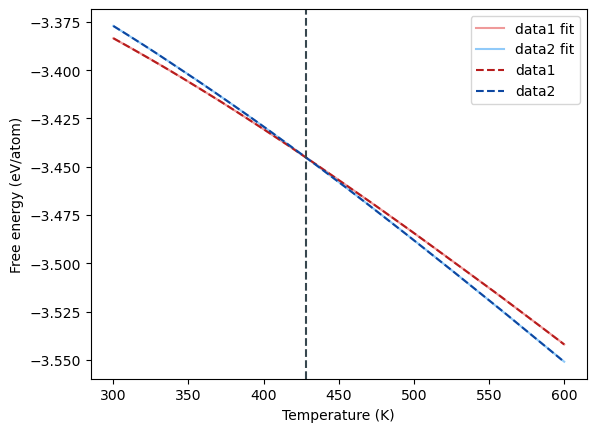

(428.0, None)

In [96]:

# Without this, when I try to reference pyiron_nodes.atomistic.property.calphy.X`, I get
# AttributeError: module 'pyiron_nodes.atomistic.property' has no attribute 'calphy'
# This must just be something with the init files not registering modules nicely over in pyiron_nodes
# My notebook is highlighting `property` as a python keyword, so maybe there is some conflict that 
# confuses things?
# Still, we never need to actually use pn_calphy, just completing the import is enough


wf = pc.Workflow('calphy2')

element = "Al"
cell_size = 3
solid_fraction = 0

wf.CubicBulkCell = nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size)
wf.Potential = nodes.atomistic.engine.lammps.Potential(structure=wf.CubicBulkCell)

wf.Tolerance = nodes.atomistic.property.calphy.Tolerance(solid_fraction=solid_fraction)
wf.InputClass = nodes.atomistic.property.calphy.InputClass()
wf.InputClass_1 = nodes.atomistic.property.calphy.InputClass(tolerance=wf.Tolerance)
wf.SolidFreeEnergyWithTemperature = nodes.atomistic.property.calphy.SolidFreeEnergyWithTemperature(structure=wf.CubicBulkCell, potential=wf.Potential, inp=wf.InputClass_1, store=False)
wf.LiquidFreeEnergyWithTemperature = nodes.atomistic.property.calphy.LiquidFreeEnergyWithTemperature(potential=wf.Potential, structure=wf.CubicBulkCell, inp=wf.InputClass, store=False)
wf.CalculatePhaseTransformationTemperature = nodes.atomistic.property.calphy.CalculatePhaseTransformationTemperature(t1=wf.SolidFreeEnergyWithTemperature.outputs.t,
                                                                                                                            f1=wf.SolidFreeEnergyWithTemperature.outputs.f, 
                                                                                                                            t2=wf.LiquidFreeEnergyWithTemperature.outputs.t, 
                                                                                                                            f2=wf.LiquidFreeEnergyWithTemperature.outputs.f) 

wf.CalculatePhaseTransformationTemperature.pull()

In [97]:
graph = base.get_full_graph_from_wf(wf)

base.pull_node(base.get_updated_graph(graph), "LiquidFreeEnergyWithTemperature")

DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!


Expanding node CubicBulkCell
Running node bulk
Running node InputClass
Running node repeat
Running node vacancy
Running node Potential
Running node LiquidFreeEnergyWithTemperature


/Users/liamhuber/dev/miniforge3/envs/pycor12/lib/python3.12/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(


(array([300.        , 300.060012  , 300.12004802, ..., 599.52038369,
        599.76009596, 600.        ]),
 array([-3.37863204, -3.37866109, -3.37869018, ..., -3.55402788,
        -3.55418321, -3.55433857]))

critical feature:
- executorlib must be able to run single node or (sub)-workflow
- executorlib is a task manager (not a workflow executor)
- library stack:
    - workflow_creator
    - workflow_executor
    - executor_lib
- application:
    - exec.submit(node)  

In [98]:
@pc.as_macro_node("transition_temperature")
def calphy2(element: str, cell_size: int = 1, solid_fraction: float = 0.7):

    from pyiron_core import nodes, Workflow

    wf = Workflow('calphy2')

    wf.CubicBulkCell = nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size)
    wf.Tolerance = nodes.atomistic.property.calphy.Tolerance(solid_fraction=solid_fraction)
    wf.InputClass = nodes.atomistic.property.calphy.InputClass()
    wf.Potential = nodes.atomistic.engine.lammps.Potential(structure=wf.CubicBulkCell)
    wf.InputClass_1 = nodes.atomistic.property.calphy.InputClass(tolerance=wf.Tolerance)
    wf.LiquidFreeEnergyWithTemperature = nodes.atomistic.property.calphy.LiquidFreeEnergyWithTemperature(potential=wf.Potential, structure=wf.CubicBulkCell, inp=wf.InputClass)
    wf.SolidFreeEnergyWithTemperature = nodes.atomistic.property.calphy.SolidFreeEnergyWithTemperature(structure=wf.CubicBulkCell, potential=wf.Potential, inp=wf.InputClass_1)
    wf.CalculatePhaseTransformationTemperature = nodes.atomistic.property.calphy.CalculatePhaseTransformationTemperature(t1=wf.SolidFreeEnergyWithTemperature.outputs.t, f1=wf.SolidFreeEnergyWithTemperature.outputs.f, t2=wf.LiquidFreeEnergyWithTemperature.outputs.t, f2=wf.LiquidFreeEnergyWithTemperature.outputs.f)

    return wf.CalculatePhaseTransformationTemperature# .outputs.transition_temp #, wf.CalculatePhaseTransformationTemperature.outputs.plot

    

It appears that macro of a macro does not work
- check!!

It does now! Calphy runs are costly, so we demo this separately now

Aside on macros within macros:

In [99]:
@pc.as_function_node
def AddOne(x):
    y = x + 1
    return y
    
@pc.as_macro_node(["y"])
def AddTwo(x):
    wf = pc.Workflow("add_two_subgraph")
    wf.n1 = AddOne(x)
    wf.n2 = AddOne(wf.n1)
    return wf.n2

@pc.as_macro_node(["y"])
def AddThree(x):
    wf = pc.Workflow("add_three_subgraph")
    wf.n1 = AddOne(x)
    wf.n2 = AddTwo(x)
    return wf.n2

wf = pc.Workflow("nested_macro_demo")
wf.nested = AddThree(0)
wf.run()

2

Note that nesting graph groups is currently still problematic: https://github.com/JNmpi/pyiron_core/issues/50

End aside on macros within macros

In [100]:
@pc.as_macro_node("transition_temperature")
def calphy2(element: str, cell_size: int = 1, solid_fraction: float = 0.7):

    from pyiron_core import nodes, Workflow

    wf = Workflow('calphy2')
    wf.CubicBulkCell = nodes.atomistic.structure.build.CubicBulkCell(element=element, cell_size=cell_size)

    return wf.CubicBulkCell

In [101]:
graph = base.Graph()
graph += nodes.atomistic.structure.build.CubicBulkCell(element="Al")
graph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,CubicBulkCell,pyiron_core.pyiron_nodes.atomistic.structure.b...,CubicBulkCell,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,"Graph(id=None, label='CubicBulkCell', root_nod...",graph,customNode,True
1,va_i_CubicBulkCell__element,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__element,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
2,va_i_CubicBulkCell__cell_size,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__cell_size,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
3,va_i_CubicBulkCell__vacancy_index,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__vacancy_index,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
4,bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,bulk,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
5,repeat,pyiron_core.pyiron_nodes.atomistic.structure.t...,repeat,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
6,vacancy,pyiron_core.pyiron_nodes.atomistic.structure.t...,vacancy,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
7,va_o_CubicBulkCell__structure,pyiron_core.pyiron_workflow.api.serial.identity,va_o_CubicBulkCell__structure,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


In [102]:
n = calphy2(element="Al")
graph = base.get_graph_from_macro_node(n)
graph.nodes

,id,import_path,label,parent_id,level,node,graph,node_type,widget_type,expanded
0,CubicBulkCell,pyiron_core.pyiron_nodes.atomistic.structure.b...,CubicBulkCell,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,"Graph(id=None, label='CubicBulkCell', root_nod...",graph,customNode,True
1,va_i_CubicBulkCell__vacancy_index,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__vacancy_index,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
2,va_i_calphy2__element,pyiron_core.pyiron_workflow.api.serial.identity,va_i_calphy2__element,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
3,va_i_calphy2__cell_size,pyiron_core.pyiron_workflow.api.serial.identity,va_i_calphy2__cell_size,None,0,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
4,va_i_CubicBulkCell__element,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__element,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
5,va_i_CubicBulkCell__cell_size,pyiron_core.pyiron_workflow.api.serial.identity,va_i_CubicBulkCell__cell_size,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
6,bulk,pyiron_core.pyiron_nodes.atomistic.structure.b...,bulk,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
7,repeat,pyiron_core.pyiron_nodes.atomistic.structure.t...,repeat,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
8,vacancy,pyiron_core.pyiron_nodes.atomistic.structure.t...,vacancy,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False
9,va_o_CubicBulkCell__structure,pyiron_core.pyiron_workflow.api.serial.identity,va_o_CubicBulkCell__structure,CubicBulkCell,1,<pyiron_core.pyiron_workflow.simple_workflow.N...,None,node,customNode,False


In [103]:
@pc.as_macro_node("structure")
def CubicBulkCell(
    element: str, cell_size: int = 1, vacancy_index: Optional[int] = None
):

    from pyiron_core import Workflow
    from pyiron_core.pyiron_nodes.atomistic.structure.build import Bulk
    from pyiron_core.pyiron_nodes.atomistic.structure.transform import (
        CreateVacancy,
        Repeat,
    )


    wf = Workflow('macro')

    wf.bulk = Bulk(name=element, cubic=True)
    wf.repeat = Repeat(structure=wf.bulk, repeat_scalar=cell_size)

    wf.vacancy = CreateVacancy(structure=wf.repeat, index=vacancy_index)
    return wf.vacancy

In [104]:
CubicBulkCell("Al").run()

DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!


Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
Al: [2.025 2.025 0.   ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.05, 4.05, 4.05])

In [105]:
nodes.atomistic.structure.build.CubicBulkCell(element="Al")

In [106]:
%%time
with executorlib.SingleNodeExecutor(max_workers=4, block_allocation=True) as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(2, 5)]
    print([f.result() for f in future_lst])

[4, 6, 8]
CPU times: user 49.5 ms, sys: 35.8 ms, total: 85.4 ms
Wall time: 143 ms


In [107]:
PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True




In [108]:
%%time
with executorlib.SingleNodeExecutor(max_workers=6, block_allocation=False) as exe:
    future_lst = [exe.submit(is_prime, n) for n in PRIMES]
    print([f.result() for f in future_lst])

[True, True, True, True, True, False]
CPU times: user 25 ms, sys: 23.7 ms, total: 48.7 ms
Wall time: 243 ms


In [109]:
%%time
with executorlib.SingleNodeExecutor(max_workers=1, block_allocation=True) as exe:
    future_lst = [exe.submit(nodes.atomistic.structure.build.Bulk()._func, n) for n in ["Al", "Fe", "Ni", "Zn"]]
    print([f.result() for f in future_lst])

[Al: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])
, Fe: [0. 0. 0.]
tags: 
    indices: [0]
    spin: [2.3]
    initial_magmoms: [2.3]
pbc: [ True  True  True]
cell: 
Cell([[-1.435, 1.435, 1.435], [1.435, -1.435, 1.435], [1.435, 1.435, -1.435]])
, Ni: [0. 0. 0.]
tags: 
    indices: [0]
    spin: [0.6]
    initial_magmoms: [0.6]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 1.76, 1.76], [1.76, 0.0, 1.76], [1.76, 1.76, 0.0]])
, Zn: [0. 0. 0.]
Zn: [4.92198874e-17 1.53575172e+00 2.46848000e+00]
tags: 
    indices: [0 0]
pbc: [ True  True  True]
cell: 
Cell([[2.66, 0.0, 0.0], [-1.33, 2.303627574066607, 0.0], [0.0, 0.0, 4.936960000000001]])
]
CPU times: user 26.4 ms, sys: 17 ms, total: 43.4 ms
Wall time: 1.43 s


In [110]:
Al = nodes.atomistic.structure.build.Bulk()._func('Al')
Al.species[0].name

'Aluminum'

In [111]:
%%time
for n in ["Al", "Fe"]:
    print(nodes.atomistic.structure.build.Bulk(n).run())

Al
Fe
CPU times: user 1.18 ms, sys: 167 μs, total: 1.35 ms
Wall time: 1.27 ms


In [112]:
elements = ['Al', 'Fe']


# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    # Start the load operations and mark each future with its URL
    futures = {executor.submit(nodes.atomistic.structure.build.Bulk()._func, el, **{'cubic': True}): el for el in elements}
    for future in concurrent.futures.as_completed(futures):
        out = futures[future]
        print("out: ", out)

        data = future.result()
        print(data.__repr__())

out:  Al
Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
Al: [2.025 2.025 0.   ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.05, 4.05, 4.05])

out:  Fe
Fe: [0. 0. 0.]
Fe: [1.435 1.435 1.435]
tags: 
    indices: [0 0]
    spin: [2.3 2.3]
    initial_magmoms: [2.3 2.3]
pbc: [ True  True  True]
cell: 
Cell([2.87, 2.87, 2.87])



In [113]:
@pc.as_function_node
def IterNode(node: pc.Node, kwarg_name: str, kwarg_list: list, max_workers: int=1, executor=None):
    # from concurrent.futures import ThreadPoolExecutor as Executor
    from executorlib import SingleNodeExecutor as Executor
    from concurrent.futures import as_completed

    out_dict = dict()
    with Executor(max_workers=max_workers) as executor:
        # Start the load operations and mark each future with its index
        futures = {executor.submit(node._func, **{kwarg_name: el}): el for el in kwarg_list}
        for future in as_completed(futures):
            out = futures[future]    
            data = future.result()
            out_dict[out] = data.species[0].name
            
            # print("out: ", out)
            # print(data.__repr__())
            
    return out_dict
    

In [114]:
%%time
elements = ['Al', 'Fe']

IterNode(nodes.atomistic.structure.build.Bulk(), "name", elements, max_workers=2).run()

copy node:  Bulk 8a76d7455b629820a4c4467fb7d92b8cd8ff6744a9264c3f841e9bbabd03807d
CPU times: user 134 ms, sys: 17.7 ms, total: 152 ms
Wall time: 1.27 s


{'Fe': 'Iron', 'Al': 'Aluminum'}

In [115]:
# Define the matrix mat and the index array ind1
mat = np.array([[0, 1, 2],
                [3, 4, 5],
                [6, 7, 8]])

ind1 = np.array([1, 0, 2])

# Compute v using advanced indexing
v = mat[ind1, np.arange(len(ind1))]

v  # Output: [3, 1, 8]

array([3, 1, 8])

In [116]:
n = nodes.atomistic.structure.build.Bulk("Al")

In [117]:
kwargs = n.kwargs
kwargs.update({"a": 2.1})
kwargs

{'name': 'Al',
 'crystalstructure': None,
 'a': 2.1,
 'c': None,
 'c_over_a': None,
 'u': None,
 'orthorhombic': False,
 'cubic': False}

In [118]:
# CLEANUP

lpg.cleanup()

cwd = pathlib.Path("../liam")

with contextlib.suppress(FileNotFoundError):
    (cwd / "NiAlH_jea.eam.alloy").unlink()

with contextlib.suppress(FileNotFoundError):
    (cwd / "pyiron.log").unlink()

for path in cwd.glob("*.dat"):
    with contextlib.suppress(FileNotFoundError):
        path.unlink()

for path in cwd.glob("*.dat-*"):
    if path.is_dir():
        with contextlib.suppress(FileNotFoundError):
            shutil.rmtree(path)

path = (cwd / ".storage")
if path.is_dir():
    with contextlib.suppress(FileNotFoundError):
        shutil.rmtree(path)

Local mode - cleaning up LocalPostgres
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', 'stop')
waiting for server to shut down.... done
server stopped
Running ('pg_ctl', '-D', '/Users/liamhuber/dev/pycor/pyiron_core/.pycor/pgdata', 'status')
